# Regrid from CESM2 to eANT025

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cf
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range, polar_stereo_inv, extend_grid_edges
from nemo_python_git.interpolation import construct_cf, construct_cf_3d, regrid_array_cf, \
                                        regrid_operator_cf, lonlat_bounds_cf

## Try a more simplified test case

In [2]:
domcfg   = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250217.nc')
meshmask = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250217.nc')

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
soseT    = xr.open_dataset(f'{base_dir}B-SOSE/climatology/THETA_climatology_202405_m01.nc')
SOSE_hinterp = xr.open_dataset(f'{base_dir}initial-conditions/temp/SOSE-PotTemp-IC-horizontal-interp.nc')

In [4]:
bc_temp = xr.open_dataset(f'{base_dir}boundary-conditions/B-SOSE/SOSE-ConsTemp-boundary-conditions-20240910_m01.nc')['ConsTemp'].isel(time_counter=0).squeeze()

In [5]:
bc_temp['deptht'] = domcfg.nav_lev.values

In [6]:
SOSE_vinterp = SOSE_hinterp.PotTemp.interp(z=domcfg.nav_lev.values)

In [7]:
zgrid = meshmask.gdept_0.isel(time_counter=0).rename({'nav_lev':'z'})

In [8]:
# SOSE_hinterp.interp(z=domcfg.nav_lev.values)
vinterp = SOSE_hinterp.interp(z=zgrid, x=zgrid.x, y=zgrid.y)

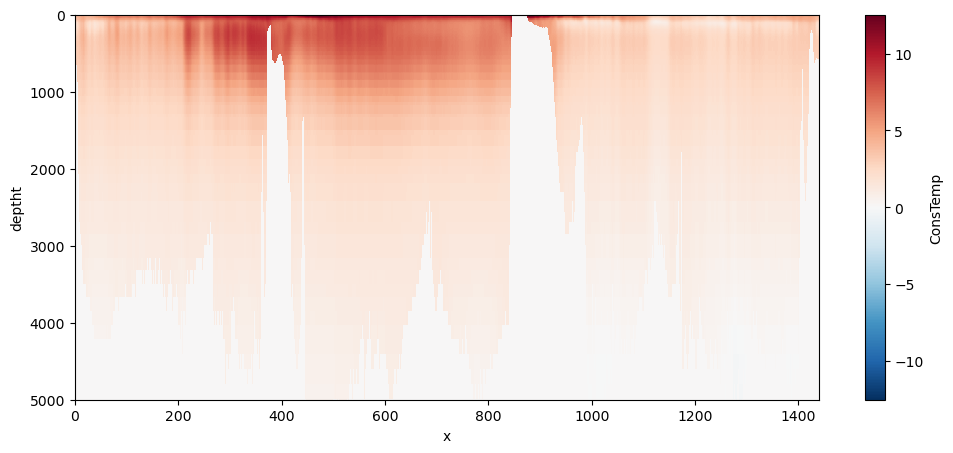

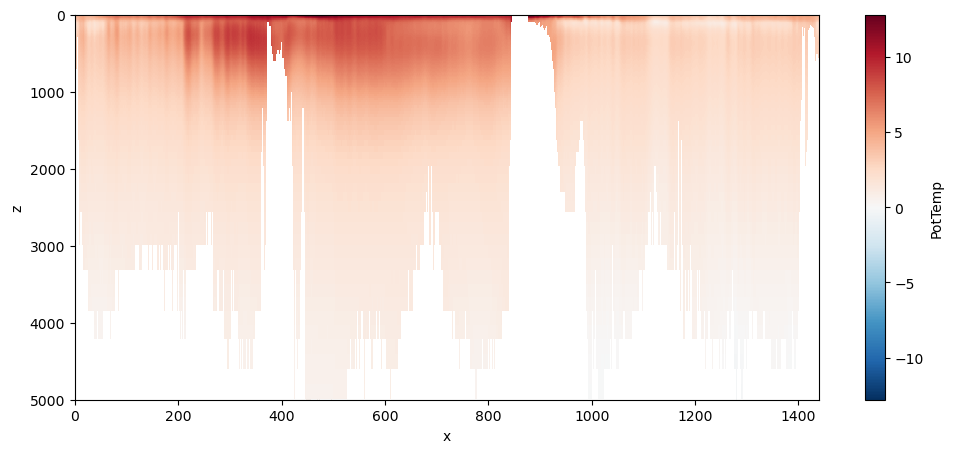

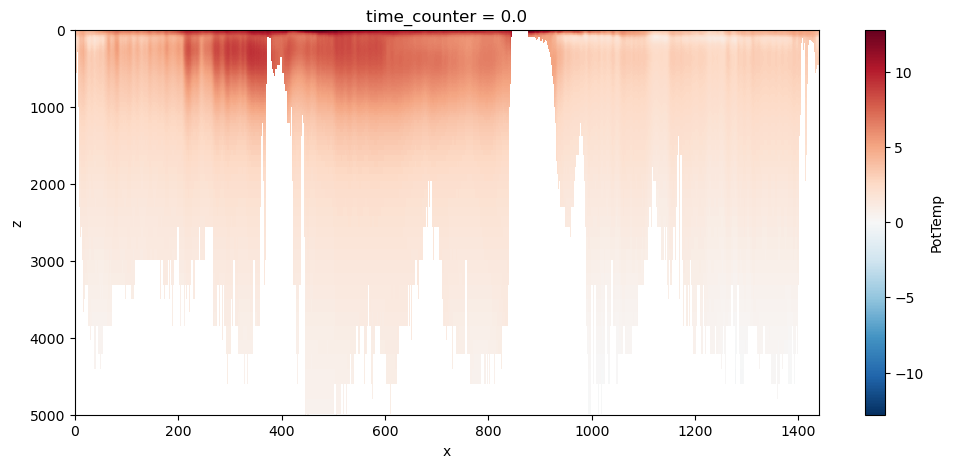

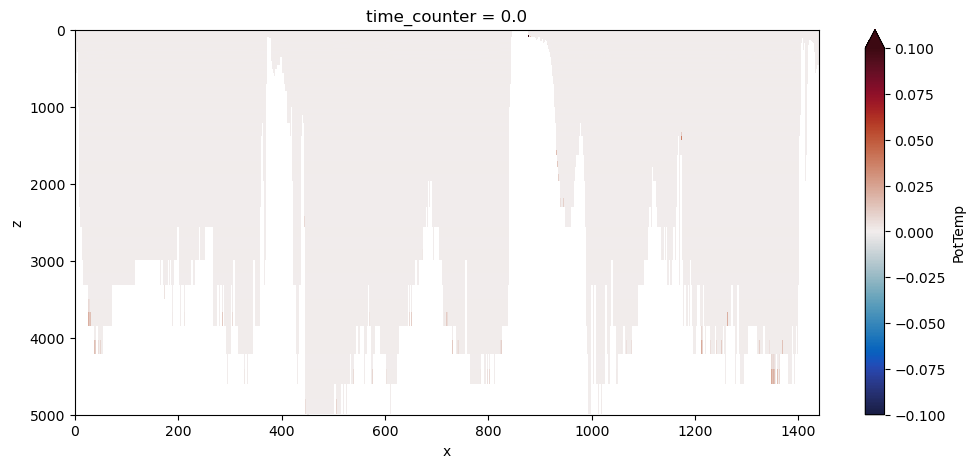

In [128]:
bc_temp.plot(figsize=(12,5), ylim=(5000, 0))
SOSE_vinterp.isel(y=-1).plot(figsize=(12,5), ylim=(5000, 0))
vinterp.PotTemp.isel(y=-1).plot(figsize=(12,5), ylim=(5000, 0))

(vinterp.PotTemp.isel(y=-1) - SOSE_vinterp.isel(y=-1)).plot(figsize=(12,5), ylim=(5000, 0), cmap=cmocean.cm.balance, vmin=-0.1, vmax=0.1)

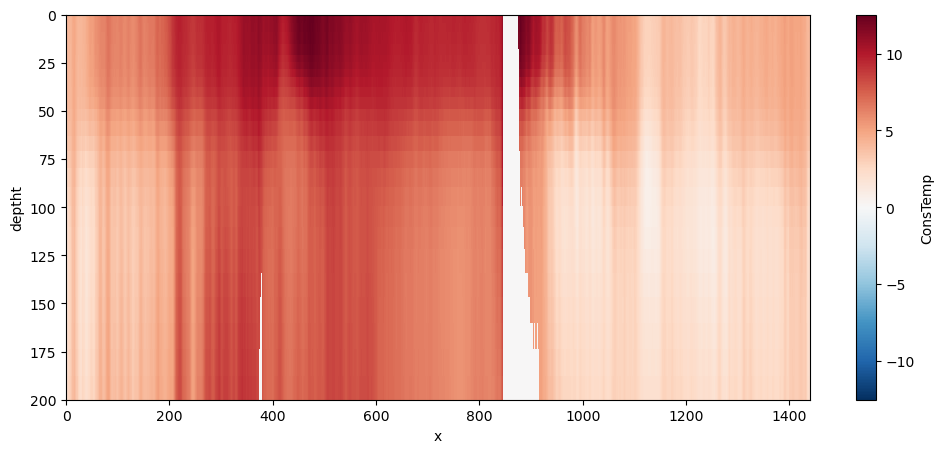

In [71]:
bc_temp.plot(figsize=(12,5), ylim=(200, 0))

In [13]:
v = cf.read(f'{base_dir}vertical.nc')[0]

In [15]:
print(v)

Field: eastward_wind (ncvar%ua)
-------------------------------
Data            : eastward_wind(time(3), air_pressure(5), grid_latitude(11), grid_longitude(10)) m s-1
Cell methods    : time(3): mean
Dimension coords: time(3) = [1979-05-01 12:00:00, 1979-05-02 12:00:00, 1979-05-03 12:00:00] gregorian
                : air_pressure(5) = [850.0, ..., 50.0] hPa
                : grid_latitude(11) = [23.32, ..., 18.919999999999987] degrees
                : grid_longitude(10) = [-20.54, ..., -16.579999999999988] degrees
Auxiliary coords: latitude(grid_latitude(11), grid_longitude(10)) = [[67.12466077223301, ..., 66.07392243542095]] degrees_north
                : longitude(grid_latitude(11), grid_longitude(10)) = [[-45.981362510049514, ..., -31.727955521179968]] degrees_east
Coord references: grid_mapping_name:rotated_latitude_longitude


In [12]:
new_z = cf.DimensionCoordinate(data=cf.Data([800, 705, 632, 510, 320.], 'hPa'))

<CF Field: eastward_wind(time(3), air_pressure(5), grid_latitude(11), grid_longitude(10)) m s-1>

In [27]:
new_z = cf.DimensionCoordinate(data=cf.Data([800, 705, 632, 510, 320.], 'hPa'))
new_v = v.regridc([new_z], axes='Z', method='linear', z='Z', ln_z=True)
print(new_v)

Field: eastward_wind (ncvar%ua)
-------------------------------
Data            : eastward_wind(time(3), Z(5), grid_latitude(11), grid_longitude(10)) m s-1
Cell methods    : time(3): mean
Dimension coords: time(3) = [1979-05-01 12:00:00, 1979-05-02 12:00:00, 1979-05-03 12:00:00] gregorian
                : Z(5) = [800.0, ..., 320.0] hPa
                : grid_latitude(11) = [23.32, ..., 18.919999999999987] degrees
                : grid_longitude(10) = [-20.54, ..., -16.579999999999988] degrees
Auxiliary coords: latitude(grid_latitude(11), grid_longitude(10)) = [[67.12466077223301, ..., 66.07392243542095]] degrees_north
                : longitude(grid_latitude(11), grid_longitude(10)) = [[-45.981362510049514, ..., -31.727955521179968]] degrees_east
Coord references: grid_mapping_name:rotated_latitude_longitude


In [40]:
new_v('Z')

TypeError: 'Field' object is not callable

In [34]:
plt.plot(new_v.array[0,0,0], new_v.Z.array)
plt.plot(v.array[0,0,0], v.air_pressure.array)

AttributeError: 'bool' object has no attribute 'array'

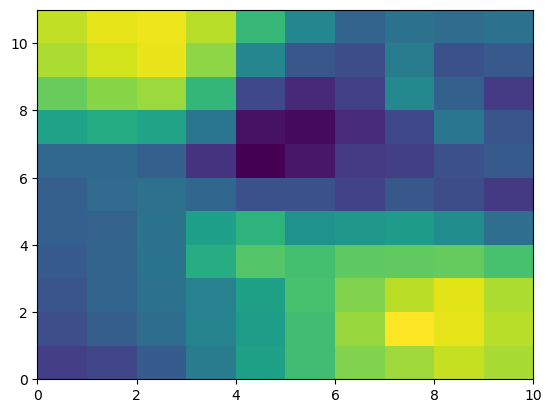

In [30]:
plt.pcolormesh(new_v.array[0,0])

In [ ]:
regridded_f = src_f.regridc(dst_f, axes='Z', method='conservative', z='Z')

## More realistic version

In [5]:
cesm2_T

<xarray.Dataset> Size: 682MB
Dimensions:    (XC: 2160, YC: 588, Z: 52)
Coordinates: (12/13)
  * XC         (XC) float32 9kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC         (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z          (Z) float32 208B -2.1 -6.7 -12.15 ... -5e+03 -5.4e+03 -5.8e+03
    rA         (YC, XC) float32 5MB ...
    Depth      (YC, XC) float32 5MB ...
    drF        (Z) float32 208B ...
    ...         ...
    maskC      (Z, YC, XC) int8 66MB ...
    maskCtrlC  (Z, YC, XC) int8 66MB ...
    rhoRef     (Z) float32 208B ...
    rLowC      (YC, XC) float32 5MB ...
    maskInC    (YC, XC) int8 1MB ...
    rSurfC     (YC, XC) float32 5MB ...
Data variables:
    PotTemp    (Z, YC, XC) float32 264MB ...

In [76]:
cesm2_var = cesm2_T.isel(time=0, nlat=slice(0,75)).rename({'TLONG':'lon', 'TLAT':'lat'})
cesm2_lon_E = fix_lon_range(cesm2_var['lon'])
cesm2_var['lon'] = cesm2_lon_E
cesm2_var['z_t'] = cesm2_var['z_t']

nemo_mesh    = meshmask.isel(time_counter=0, x=slice(500,550), y=slice(150,None))

cesm2_source = cesm2_var.assign({'depth':cesm2_var.z_t}).rename({'ConsTemp':'data', 'nlat':'y', 'nlon':'x', 'z_t':'z'})
nemo_dest    = nemo_mesh.rename({'nav_lon':'lon', 'nav_lat':'lat', 'nav_lev':'z', 'gdept_0':'depth'})

lonbnd_src , latbnd_src  = lonlat_bounds_cf(cesm2_source, ds_type='src' , pster_src=True, method='conservative')
lonbnd_nemo, latbnd_nemo = lonlat_bounds_cf(nemo_dest   , ds_type='nemo', method='conservative')
cesm2_dep_bounds = np.array((np.insert(cesm2_T.z_t.values[:-1], 0, 0), np.append(cesm2_T.z_t.values[1:], 5625))).transpose()
nemo_dep_bounds  = np.array((np.insert(nemo_dest.z.values[:-1], 0, 0), np.append(nemo_dest.z.values[1:], 6107))).transpose()
cesm2_source = cesm2_source.assign({'lon_bounds':(('y','x','edges'), lonbnd_src), 
                                    'lat_bounds':(('y','x','edges'), latbnd_src),
                                    'dep_bounds':(('z', 'layer'), cesm2_dep_bounds)})
nemo_dest    = nemo_dest.assign({'lon_bounds':(('y','x','edges'), lonbnd_nemo), 
                                 'lat_bounds':(('y','x','edges'), latbnd_nemo),
                                 'dep_bounds':(('z', 'layer'), nemo_dep_bounds)})

In [78]:
cf_source = construct_cf_3d(cesm2_source['data'], cesm2_source['x'], cesm2_source['y'], cesm2_source['z'],
                            lon=cesm2_source['lon'], lat=cesm2_source['lat'], depth=cesm2_source['depth'],
                            lon_bounds=cesm2_source['lon_bounds'],
                            lat_bounds=cesm2_source['lat_bounds'],
                            dep_bounds=cesm2_source['dep_bounds'])

In [84]:
dummy_data = np.zeros([nemo_dest.sizes['z'], nemo_dest.sizes['y'], nemo_dest.sizes['x']]) # to specify dims
cf_nemo = construct_cf_3d(dummy_data, nemo_dest['x'], nemo_dest['y'], nemo_dest['z'],
                          lon=nemo_dest['lon'], lat=nemo_dest['lat'], depth=nemo_dest['depth'].isel(y=0,x=0),
                          lon_bounds=nemo_dest['lon_bounds'],
                          lat_bounds=nemo_dest['lat_bounds'],
                          dep_bounds=nemo_dest['dep_bounds'],)

In [ ]:
ro = cf_source.regrids(cf_nemo, method='conservative', ln_z=False) #src_z='Z', dst_z='Z')

In [99]:
ra = cf_source.regrids(ro, method='bilinear', ln_z=True)

In [ ]:
regridded_array = src.regrids(regrid_operator, dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, method=method,
                                  src_cyclic=src_cyclic, dst_cyclic=dst_cyclic)

In [92]:
nemo_mesh

<xarray.Dataset> Size: 98MB
Dimensions:       (y: 303, x: 50, nav_lev: 121)
Coordinates:
  * nav_lev       (nav_lev) float32 484B 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_counter  float32 4B 0.0
Dimensions without coordinates: y, x
Data variables: (12/49)
    nav_lon       (y, x) float32 61kB ...
    nav_lat       (y, x) float32 61kB ...
    jpiglo        int32 4B ...
    jpjglo        int32 4B ...
    jpkglo        int32 4B ...
    jperio        int32 4B ...
    ...            ...
    e3v_0         (nav_lev, y, x) float64 15MB ...
    e3w_0         (nav_lev, y, x) float64 15MB ...
    gdept_1d      (nav_lev) float64 968B ...
    gdepw_1d      (nav_lev) float64 968B ...
    gdept_0       (nav_lev, y, x) float64 15MB ...
    gdepw_0       (nav_lev, y, x) float64 15MB ...
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1 2]
    DOMAIN_size_global:      [1440  453]
    DOMAIN_size_local:       [1440  453]
    DOMAIN_position_first:   [1 1]
    DOMAIN_position_last:    [1440  453]
    DOMAIN_halo_size_start:  [0 0]
    DOMAIN_halo_size_end:    [0 0]
    DOMAIN_type:             BOX

In [100]:
ra.array.shape

(60, 303, 50)

In [94]:
cf_source

<CF Field: (axis=Z(60), axis=Y(75), axis=X(320))>

In [ ]:
regrid_operator = src.regrids(dst, method=method, src_z='Z', dst_z='Z', ln_z=ln_z,
                                      dst_axes={'X':'X','Y':'Y','Z':'Z'}, src_axes={'X':'X','Y':'Y','Z':'Z'},
                                      use_dst_mask=use_dst_mask, src_cyclic=src_cyclic, dst_cyclic=dst_cyclic,
                                      return_operator=True)

In [46]:
def construct_cf_3d(data, x, y, z, lon=None, lat=None, depth=None, 
                    lon_bounds=None, lat_bounds=None, dep_bounds=None):
    import cf

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var

    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    depth = convert_np(depth)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'm'), properties={'axis':'Z'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lon.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
    
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    dim_lat.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
    
    dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(depth, 'meters'), properties={'standard_name':'depth'})
    dim_dep.set_bounds(cf.Bounds(data=cf.Data(dep_bounds, 'meters')))
    if depth.ndim == 3:
        field.set_construct(dim_dep, axes=('Z','Y','X'))
    elif depth.ndim == 1:
        field.set_construct(dim_dep, axes=('Z'))
    else:
        raise Exception('Depth variable must be either 1D (Z) or 3D (Z,Y,X)')

    field.set_data(cf.Data(data), axes=('Z','Y','X'))
    return field


In [ ]:
def regrid_operator_cf(source, destination, key_3d=True, method='linear', ln_z=False, use_dst_mask=True,
                       src_cyclic=False, dst_cyclic=False):
    import cf

    if key_3d: # 3D regridding
        dummy_data = np.zeros([destination.sizes['z'], destination.sizes['y'], destination.sizes['x']]) # to specify dims
        src = construct_cf_3d(source['data'], source['x'], source['y'], source['z'],
                              lon=source['lon'], lat=source['lat'], depth=source['depth'])
        dst = construct_cf_3d(dummy_data, destination['x'], destination['y'], destination['z'],
                              lon=destination['lon'], lat=destination['lat'], depth=destination['depth'])

        # calculate regridding operator with cf
        regrid_operator = src.regrids(dst, method=method, src_z='Z', dst_z='Z', ln_z=ln_z,
                                      dst_axes={'X':'X','Y':'Y','Z':'Z'}, src_axes={'X':'X','Y':'Y','Z':'Z'},
                                      use_dst_mask=use_dst_mask, src_cyclic=src_cyclic, dst_cyclic=dst_cyclic,
                                      return_operator=True)
    else: # 2D regridding
        dummy_data = np.zeros([destination.sizes['y'], destination.sizes['x']]) # to specify dims
        src = construct_cf(source['data'], source['x']     , source['y']     , lon=source['lon']     , lat=source['lat'])#,
                           #lon_bounds=source['lon_bounds'] , lat_bounds=source['lat_bounds'])
        dst = construct_cf(dummy_data    , destination['x'], destination['y'], lon=destination['lon'], lat=destination['lat'])#,
                           #lon_bounds=destination['lon_bounds'], lat_bounds=destination['lat_bounds'])

        # calculate regridding operator with cf
        regrid_operator = src.regrids(dst, method=method, dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'},
                                      use_dst_mask=use_dst_mask, src_cyclic=src_cyclic, dst_cyclic=dst_cyclic)

    return regrid_operator

In [ ]:
def regrid_array_cf(source, regrid_operator, key_3d=True, method='linear', src_cyclic=False, dst_cyclic=False):
    import cf

    if key_3d:
        src = construct_cf_3d(source['data'], source['x'], source['y'], source['z'],
                              lon=source['lon'], lat=source['lat'], depth=source['depth'])
    else:
        src = construct_cf(source['data'], source['x'], source['y'], lon=source['lon'], lat=source['lat'])#, 
                          # lon_bounds=source['lon_bounds'], lat_bounds=source['lat_bounds'])

    regridded_array = src.regrids(regrid_operator, dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, method=method,
                                  src_cyclic=src_cyclic, dst_cyclic=dst_cyclic)

    return regridded_array


In [4]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_2d (data, x, y, lon=None, lat=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
        
    field.set_data(cf.Data(data), axes=('Y','X'))
    return field

In [5]:
# Function similar to "construct_cf" but for 3D variables to construct a minimal CF field so cf-python can do regridding
# Have not yet generalized to take only lat lon depth without needing to specify x,y,z when that's possible
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
# Input:
# - data  : xarray variable of dimensions (z,y,x) to be regridded
# - x     : 1D x coordinates 
# - y     : 1D y coordinates 
# - z     : 1D z coordinates 
# - lon   : 2D longitude values
# - lat   : 2D latitude values
# - depth : 1D or 3D array of grid depth points
def construct_cf_3d(data, x, y, z, lon=None, lat=None, depth=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    depth = convert_np(depth)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'm'), properties={'axis':'Z'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(depth, 'meters'), properties={'standard_name':'depth'})
    if depth.ndim == 3:
        field.set_construct(dim_dep, axes=('Z','Y','X'))
    elif depth.ndim == 1:
        field.set_construct(dim_dep, axes=('Z'))
    else: 
        raise Exception('Depth variable must be either 1D (Z) or 3D (Z,Y,X)')
        
    field.set_data(cf.Data(data), axes=('Z','Y','X'))
    return field

In [107]:
# Function to create a cf regrid operator that regrids source to destination
# currently, cf allows conservative regridding for 2d arrays only unfortunately
# Input:
# - source : xarray dataset containing: x, y, z, lon, lat, data, depth, (lon_bounds, lat_bounds --- only for 2d)
#            lon_bounds and lat_bounds can be calculated with lonlat_bounds_cf
#            (might require some pre-processing to rename the variables)
# - (optional) key_3d : boolean indicating whether to regrid a 3D array or 2D array
# - (optional) filename : string of location to save the pickle, for example: regrid-test.pickle
def regrid_operator_cf(source, destination, key_3d=True, filename=None, 
                       method='linear', ln_z=False, use_dst_mask=True, 
                       src_cyclic=False, dst_cyclic=False):

    if key_3d: # 3D regridding
        dummy_data = np.zeros([destination.sizes['z'], destination.sizes['y'], destination.sizes['x']]) # to specify dims
        src = construct_cf_3d(source['data'], source['x'], source['y'], source['z'],
                              lon=source['lon'], lat=source['lat'], depth=source['depth'])
        dst = construct_cf_3d(dummy_data, destination['x'], destination['y'], destination['z'],
                              lon=destination['lon'], lat=destination['lat'], depth=destination['depth'])

        # calculate regridding operator with cf
        regrid_operator = src.regrids(dst, method=method, src_z='Z', dst_z='Z', ln_z=ln_z, 
                                      dst_axes={'X':'X','Y':'Y','Z':'Z'}, src_axes={'X':'X','Y':'Y','Z':'Z'}, 
                                      use_dst_mask=use_dst_mask, src_cyclic=src_cyclic, dst_cyclic=dst_cyclic, 
                                      return_operator=True)    
    else: # 2D regridding
        dummy_data = np.zeros([destination.sizes['y'], destination.sizes['x']]) # to specify dims
        src = construct_cf(source['data'], source['x']     , source['y']     , lon=source['lon']     , lat=source['lat'],
                           lon_bounds=source['lon_bounds'] , lat_bounds=source['lat_bounds'])
        dst = construct_cf(dummy_data    , destination['x'], destination['y'], lon=destination['lon'], lat=destination['lat'],
                           lon_bounds=destination['lon_bounds'], lat_bounds=destination['lat_bounds'])

        # calculate regridding operator with cf
        regrid_operator = src.regrids(dst, method=method, dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'},
                                      use_dst_mask=use_dst_mask, src_cyclic=src_cyclic, dst_cyclic=dst_cyclic)

    if filename:
        import pickle
        with open(filename, 'wb') as handle:
            pickle.dump(regrid_operator, handle)
        # reload with pickle.load(handle)
    
    return regrid_operator

# Function regrids the given source cf construct using the regrid operator calculated by regrid_operator_cf
# Inputs:
# - source : cf construct of the source data to regrid to a new grid specified by the operator
# - regrid_operator : cf regrid operator (produced by function cf_regrid_operator)
# - (optional) key_3d : boolean to specify whether you want to regrid 3D data
# - (optional) method : method used for cf regridding; should be the same as what was specified to create the cf regrid operator
def regrid_array_cf(source, regrid_operator, key_3d=True, method='linear'):

    if key_3d:
        src = construct_cf_3d(source['data'], source['x'], source['y'], source['z'],
                              lon=source['lon'], lat=source['lat'], depth=source['depth'])
    else:
        src = construct_cf(source['data'], source['x'], source['y'], lon=source['lon'], lat=source['lat'], 
                           lon_bounds=source['lon_bounds'], lat_bounds=source['lat_bounds'])

    regridded_array = src.regrids(regrid_operator, dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, method=method)
    
    return regridded_array

In [65]:
# Helper function to calculate longitude and latitude bounds for cf (following Kaitlin's interp_latlon_cf function)
# Inputs:
# - dataset : xarray dataset to calculate edges for
# - (optional) ds_type : either src or nemo (type of grid to calculate edges of)
# - (optional) method  : cf regridding method that the bounds will be used for
def lonlat_bounds_cf(dataset, ds_type='src', method='linear', periodic_src=False, pster_src=False, periodic_nemo=True):

    # Helper function to get an xarray DataArray of edges (size N+1, or N+1 by M+1) into a Numpy array of bounds for CF (size N x 2, or N x M x 4)
    def edges_to_bounds (edges):
        if len(edges.shape)==1:
            # 1D variable
            bounds = np.empty([edges.shape[0]-1, 2])
            bounds[...,0] = edges.values[:-1]
            bounds[...,1] = edges.values[1:]
        elif len(edges.shape)==2:
            # 2D variable
            bounds = np.empty([edges.shape[0]-1, edges.shape[1]-1, 4])
            bounds[...,0] = edges.values[:-1,:-1]  # SW corner
            bounds[...,1] = edges.values[:-1,1:] # SE
            bounds[...,2] = edges.values[1:,1:] # NE
            bounds[...,3] = edges.values[1:,:-1] # NW
        return bounds

    if method == 'conservative':
        if ds_type=='src':
            if len(dataset['x'].shape) != 1:
                raise Exception('Cannot find bounds if source dataset not a regular grid')
            # Get grid cell edges for x and y
            def construct_edges (array, dim):
                centres = 0.5*(array[:-1] + array[1:])
                if periodic_src and dim=='lon':
                    first_edge = 0.5*(array[0] + array[-1] - 360)
                    last_edge  = 0.5*(array[0] + 360 + array[-1])
                else:
                    first_edge = 2*array[0] - array[1]
                    last_edge  = 2*array[-1] - array[-2]
                edges = np.concatenate(([first_edge], centres, [last_edge]))
                return xr.DataArray(edges, coords={dim:edges})
            x_edges = construct_edges(dataset['x'].values, 'x')
            y_edges = construct_edges(dataset['y'].values, 'y')
            if pster_src:
                # Now convert to lat-lon
                lon_edges, lat_edges = polar_stereo_inv(x_edges, y_edges)
            else:
                lon_edges = x_edges
                lat_edges = y_edges
            lon_bounds = edges_to_bounds(lon_edges)
            lat_bounds = edges_to_bounds(lat_edges)
        elif ds_type=='nemo':
            def construct_nemo_bounds (array):
                edges = extend_grid_edges(array, 'f', periodic=periodic_nemo)
                return edges_to_bounds(edges)
            if ('glamt' in dataset) and ('gphif' in dataset):
                lon_bounds = construct_nemo_bounds(dataset['glamt'])
                lat_bounds = construct_nemo_bounds(dataset['gphif'])
            elif ('bounds_lon' in dataset) and ('bounds_lat' in dataset):
                lon_bounds = dataset['bounds_lon']
                lat_bounds = dataset['bounds_lat']
            elif ('bounds_nav_lon_grid_T' in dataset) and ('bounds_nav_lat_grid_T' in dataset):
                lon_bounds = dataset['bounds_nav_lon_grid_T']
                lat_bounds = dataset['bounds_nav_lat_grid_T']
            else:
                raise Exception('dataset does not contain the necessary variables for ds_type nemo. Should contain glamt, gphif, or bounds_lon, bounds_lat')
        else:
            raise Exception('ds_type must be one of src or nemo')
    else:
        lon_bounds = None
        lat_bounds = None
        
    return lon_bounds, lat_bounds

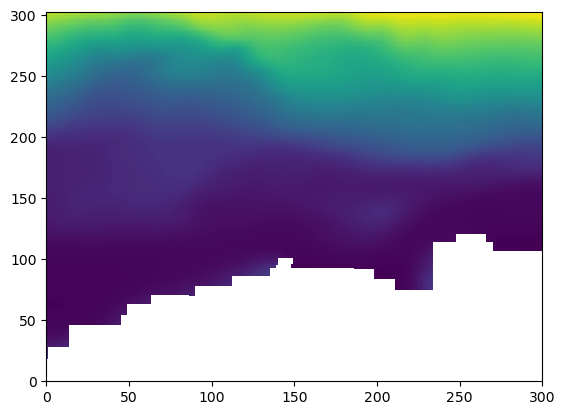

In [151]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70), z_t=0)

nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=0)
dummy_data    = np.zeros([nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])

src_sub = construct_cf_3d2d(start_cesm2_sub['ConsTemp'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'],
                          lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])
dst_sub = construct_cf_3d2d(nemo_mesh_sub['e3t_0'], nemo_mesh_sub['x'], nemo_mesh_sub['y'],
                          lon=nemo_mesh_sub['nav_lon'], lat=nemo_mesh_sub['nav_lat'])

src_regrid = src_sub.regrids(dst_sub, method='linear',
                             dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, use_dst_mask=True,
                             src_cyclic=False, dst_cyclic=False)

ds = src_regrid.array
plt.pcolormesh(ds[:,:])